-----
## Install + Imports

In [ ]:
!pip install -q transformers accelerate

In [ ]:
from google.colab import drive
import os
import numpy as np

import glob
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.model_selection import train_test_split
from tqdm import tqdm


-----

## Data Acquisition & Preprocessing

 **extracting frames** from those videos.

### Step 2.1: Mount Google Drive and Install Libraries

You'll need `Pytorch` and `torchvision` (which you have), `scikit-learn` for splitting, and `opencv-python` for video frame extraction.

In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Install necessary libraries (if not already installed)
!pip install opencv-python tqdm

# Base paths
DRIVE_PATH = '/content/drive/MyDrive/Final Project Adv ML/'
DATASET_NAME = 'celeb-df-v2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 2.2: Extract Frames and Create Labels

The most performance-intensive part is converting videos into individual image frames, which the deep learning model requires.

In [ ]:
# 0. Set the correct path to your frames folder
# Folder structure:
# /content/drive/MyDrive/Final Project Adv ML/celeb-df-v2/frames/
#   ├── real/
#   └── fake/
FRAME_OUTPUT_DIR = "/content/drive/MyDrive/Final Project Adv ML/celeb-df-v2/frames"
#REAL_VIDEO_DIR = "/content/drive/MyDrive/Final Project Adv ML/celeb-df-v2/frames/real"
#FAKE_VIDEO_DIR = "/content/drive/MyDrive/Final Project Adv ML/celeb-df-v2/frames/fake"

print("FRAME_OUTPUT_DIR:", FRAME_OUTPUT_DIR)
print("Subfolders:", os.listdir(FRAME_OUTPUT_DIR))

FRAME_OUTPUT_DIR: /content/drive/MyDrive/Final Project Adv ML/celeb-df-v2/frames
Subfolders: ['real', 'fake']


In [ ]:
"""
# 1. EXTRACT FRAMES IF FOLDERS EMPTY
def extract_frames(video_path, output_dir, label, frames_per_video=30):

    #Extracts a fixed number of frames from a video and saves them under: output_dir/label/

    video_name = os.path.basename(video_path).split('.')[0]
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Guard against broken/unreadable videos
    if frame_count <= 0:
        cap.release()
        return 0

    # Evenly sample frames
    step = frame_count // frames_per_video if frame_count >= frames_per_video else 1
    frame_indices = np.arange(0, frame_count, step)[:frames_per_video]
    frame_indices_set = set(frame_indices.tolist())

    frames_extracted = 0
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        if i in frame_indices_set:
            frame_filename = os.path.join(output_dir, label, f'{video_name}_frame_{i:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            frames_extracted += 1

    cap.release()
    return frames_extracted

# Check if we already have jpgs
real_jpgs = glob.glob(os.path.join(REAL_FRAME_DIR, "*.jpg"))
fake_jpgs = glob.glob(os.path.join(FAKE_FRAME_DIR, "*.jpg"))

print("Existing REAL jpgs:", len(real_jpgs))
print("Existing FAKE jpgs:", len(fake_jpgs))

# Only extract if empty (your current situation)
if len(real_jpgs) == 0 or len(fake_jpgs) == 0:
    print("No frames found – starting extraction...")

    video_exts = ('*.mp4', '*.avi', '*.mov')

    real_videos = [p for ext in video_exts for p in glob.glob(os.path.join(REAL_VIDEO_DIR, ext))]
    fake_videos = [p for ext in video_exts for p in glob.glob(os.path.join(FAKE_VIDEO_DIR, ext))]

    print(f"Found {len(real_videos)} REAL videos and {len(fake_videos)} FAKE videos.")

    print("--- Starting REAL video frame extraction ---")
    for video_file in tqdm(real_videos):
        extract_frames(video_file, FRAME_OUTPUT_DIR, 'real')

    print("\n--- Starting FAKE video frame extraction ---")
    for video_file in tqdm(fake_videos):
        extract_frames(video_file, FRAME_OUTPUT_DIR, 'fake')

    # Re-count after extraction
    real_jpgs = glob.glob(os.path.join(REAL_FRAME_DIR, "*.jpg"))
    fake_jpgs = glob.glob(os.path.join(FAKE_FRAME_DIR, "*.jpg"))
    print("After extraction - REAL jpgs:", len(real_jpgs))
    print("After extraction - FAKE jpgs:", len(fake_jpgs))
else:
    print("Frames already exist – skipping extraction.")
"""

### Step 2.3: Create Train/Val/Test Splits and Dataloaders

Once the images are extracted, you need to use `torchvision` and `scikit-learn` to set up the data pipeline.

In [ ]:
# 1. Define Values
IMAGE_SIZE = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

SUBSET_SIZE = 5000
BATCH_SIZE = 256
NUM_WORKERS = min(8, os.cpu_count())

# 2. Prepare Data
print("Loading dataset...")
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# run this first: root=FRAME_OUTPUT_DIR, then run root="/content/drive/MyDrive/Final Project Adv ML/celeb-df-v2/frames"
# then run root="/content/drive/MyDrive/frames"
full_dataset = datasets.ImageFolder(root=FRAME_OUTPUT_DIR, transform=transform)

print("Classes:", full_dataset.classes)
print(f"Total Frames Available: {len(full_dataset)}")

# Apply balanced subset if configured
all_targets = np.array(full_dataset.targets)

if SUBSET_SIZE is not None and len(full_dataset) > SUBSET_SIZE:
    all_indices = np.arange(len(full_dataset))

    # Get indices for each class
    unique_classes = np.unique(all_targets)
    samples_per_class = SUBSET_SIZE // len(unique_classes)

    print(f"Selecting {samples_per_class} samples per class for balanced subset")

    subset_indices = []
    for cls in unique_classes:
        cls_indices = all_indices[all_targets == cls]

        # Sample from this class
        if len(cls_indices) >= samples_per_class:
            selected = np.random.choice(cls_indices, size=samples_per_class, replace=False)
        else:
            print(f"⚠️  Warning: Class {full_dataset.classes[cls]} has only {len(cls_indices)} samples, using all")
            selected = cls_indices

        subset_indices.extend(selected)

    subset_indices = np.array(subset_indices)
    np.random.shuffle(subset_indices)  # Shuffle to mix classes

    full_dataset = Subset(full_dataset, subset_indices)
    targets = all_targets[subset_indices]
    print(f"Using balanced subset of {len(subset_indices)} frames")
else:
    targets = all_targets

num_samples = len(full_dataset)
print(f"Frames used for training: {num_samples}")

# Show class distribution
unique, counts = np.unique(targets, return_counts=True)
for cls, count in zip(unique, counts):
    cls_name = full_dataset.dataset.classes[cls] if isinstance(full_dataset, Subset) else full_dataset.classes[cls]
    print(f"  {cls_name}: {count} ({count/len(targets)*100:.1f}%)")

# Stratified splits (80% train, 10% val, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

indices = np.arange(num_samples)

# First split: train vs (val+test)
train_indices, val_test_indices = train_test_split(
    indices,
    train_size=train_ratio,
    stratify=targets,
    random_state=42
)

# Second split: val vs test
val_test_targets = targets[val_test_indices]
val_size_relative = val_ratio / (val_ratio + test_ratio)

val_indices, test_indices = train_test_split(
    val_test_indices,
    train_size=val_size_relative,
    stratify=val_test_targets,
    random_state=42
)

# Create Subset datasets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

# 3. Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                          pin_memory=True, persistent_workers=True, prefetch_factor=2)

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                        pin_memory=True, persistent_workers=True, prefetch_factor=2)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                         pin_memory=True, persistent_workers=True, prefetch_factor=2)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Loading dataset...
Classes: ['fake', 'real']
Total Frames Available: 186781
Selecting 2500 samples per class for balanced subset
Using balanced subset of 5000 frames
Frames used for training: 5000
  fake: 2500 (50.0%)
  real: 2500 (50.0%)
Train: 4000 | Val: 500 | Test: 500
Train batches: 16 | Val batches: 2 | Test batches: 2


---
## Transfer Learning Model Setup

## Defining a MLP Head

In [ ]:
import torch.nn as nn

class MLPHead(nn.Module):
    def __init__(self, in_features, hidden_dim=512, num_labels=2, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),                      # or GELU for ViT-style
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels)
        )

    def forward(self, x):
        return self.net(x)


## Load the Hugging Face pretrained model

In [ ]:
print("\nLoading model...")
model_name = "prithivMLmods/Deep-Fake-Detector-v2-Model"

id2label = {0: "real", 1: "fake"}
label2id = {v: k for k, v in id2label.items()}

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

processor = ViTImageProcessor.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Loaded model:", model_name)
print(f"Using device: {device}")


Loading model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded model: prithivMLmods/Deep-Fake-Detector-v2-Model
Using device: cuda


## Freeze / Unfreeze Layers

In [ ]:
# 1) Freeze the ViT backbone
for p in model.vit.parameters():
    p.requires_grad = False

# 2) Replace classifier with an MLP head
in_features = model.classifier.in_features
model.classifier = MLPHead(
    in_features=in_features,
    hidden_dim=512,   # try 256/512/1024
    num_labels=2,
    dropout=0.1
)

# 3) Keep config consistent
model.config.num_labels = 2
model.config.id2label = id2label
model.config.label2id = label2id

model.to(device)

"""
# (Optional) compile AFTER all modifications
try:
    model = torch.compile(model)
    print("✅ Model compiled with torch.compile")
except Exception as e:
    print("⚠️  torch.compile skipped:", e)
"""

model.to(device)
print("✅ Model ready for training (without compilation)")

# Verify no compilation
if hasattr(model, '_orig_mod'):
    print("⚠️  WARNING: Model is compiled!")
else:
    print("✅ Model is NOT compiled")


✅ Model ready for training (without compilation)
✅ Model is NOT compiled


## Quick sanity check
 Right after setting up the MLP head, check:

In [ ]:
def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_params(model)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 86,193,410
Trainable parameters: 394,754


## Training & Evaluation Loop (Baseline Run)

In [ ]:
NUM_EPOCHS = 20
WEIGHT_DECAY = 1e-4
ACCUMULATION_STEPS = 1

# Label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Differential learning rates (RECOMMENDED)
optimizer = AdamW([
    {'params': model.vit.parameters(), 'lr': 1e-5},      # Lower for pretrained backbone
    {'params': model.classifier.parameters(), 'lr': 5e-4}  # Higher for new head
], weight_decay=WEIGHT_DECAY)

# OneCycleLR with matching max_lr list
from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(
    optimizer,
    max_lr=[1e-5, 5e-4],  # MUST match number of param groups (2)
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

scaler = torch.amp.GradScaler('cuda')

print(f"✅ Optimizer created with {len(optimizer.param_groups)} parameter groups")
print(f"   Group 0 (backbone): lr={optimizer.param_groups[0]['lr']}")
print(f"   Group 1 (head): lr={optimizer.param_groups[1]['lr']}")

✅ Optimizer created with 2 parameter groups
   Group 0 (backbone): lr=3.9999999999999956e-07
   Group 1 (head): lr=1.9999999999999998e-05


In [ ]:
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
ACCUMULATION_STEPS = 1  # Set to 2-4 if you need larger effective batch size

# Training Components
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(
    optimizer,
    max_lr=[1e-5, 5e-4],
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1
)
# Steps inside train_one_epoch after optimizer.step()

scaler = torch.amp.GradScaler('cuda')


def train_one_epoch(model, loader, optimizer, criterion, device, scaler, scheduler, accumulation_steps=1):
    #Train for one epoch with mixed precision and gradient accumulation.
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)

    for i, (images, labels) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Mixed precision forward pass
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(pixel_values=images)

            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs

            loss = criterion(logits, labels)

            if accumulation_steps > 1:
                loss = loss / accumulation_steps

        # Backward pass
        scaler.scale(loss).backward()

        # Update weights every accumulation_steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(loader):  # Added end of epoch check
            # FIX: Always unscale before step
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Step scheduler after optimizer step (for OneCycleLR)
            if scheduler is not None:
                scheduler.step()

        # Metrics
        running_loss += loss.item() * images.size(0) * accumulation_steps
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Show current LR in progress bar
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{correct/total:.4f}",
            "lr": f"{current_lr:.2e}"
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """Evaluate model with mixed precision."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            for images, labels in pbar:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(pixel_values=images)

                if hasattr(outputs, 'logits'):
                  logits = outputs.logits
                else:
                  logits = outputs

                loss = criterion(logits, labels)

                running_loss += loss.item() * images.size(0)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{correct/total:.4f}"})

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## Run training (baseline)

In [ ]:
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

best_val_acc = 0.0
best_val_loss = float('inf')
patience = 3
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    # Train - pass scheduler now
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device, scaler, scheduler, ACCUMULATION_STEPS
    )

    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    print(f"LR: {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        patience_counter = 0

        save_path = "/content/drive/MyDrive/Final Project Adv ML/baseline_deepfake_vit_best.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, save_path)
        print(f"✅ Saved new best model (Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"⚠️  No improvement ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Test Evaluation
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")

print("\n✅ Training complete!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Final test accuracy: {test_acc:.4f}")


STARTING TRAINING

Epoch 1/20
--------------------------------------------------


Train - Loss: 0.6911, Acc: 0.5282
Val   - Loss: 0.6859, Acc: 0.5720
LR: 0.000005
✅ Saved new best model (Val Acc: 0.5720)

Epoch 2/20
--------------------------------------------------


Train - Loss: 0.6730, Acc: 0.6055
Val   - Loss: 0.6637, Acc: 0.6200
LR: 0.000010
✅ Saved new best model (Val Acc: 0.6200)

Epoch 3/20
--------------------------------------------------


Train - Loss: 0.6482, Acc: 0.6462
Val   - Loss: 0.6471, Acc: 0.6500
LR: 0.000010
✅ Saved new best model (Val Acc: 0.6500)

Epoch 4/20
--------------------------------------------------


Train - Loss: 0.6302, Acc: 0.6637
Val   - Loss: 0.6399, Acc: 0.6640
LR: 0.000010
✅ Saved new best model (Val Acc: 0.6640)

Epoch 5/20
--------------------------------------------------


Train - Loss: 0.6099, Acc: 0.6910
Val   - Loss: 0.6463, Acc: 0.6340
LR: 0.000009
⚠️  No improvement (1/3)

Epoch 6/20
--------------------------------------------------


Train - Loss: 0.5949, Acc: 0.7117
Val   - Loss: 0.6313, Acc: 0.6800
LR: 0.000009
✅ Saved new best model (Val Acc: 0.6800)

Epoch 7/20
--------------------------------------------------


Train - Loss: 0.5788, Acc: 0.7260
Val   - Loss: 0.6355, Acc: 0.6780
LR: 0.000008
⚠️  No improvement (1/3)

Epoch 8/20
--------------------------------------------------


Train - Loss: 0.5665, Acc: 0.7408
Val   - Loss: 0.6265, Acc: 0.6760
LR: 0.000007
⚠️  No improvement (2/3)

Epoch 9/20
--------------------------------------------------


Train - Loss: 0.5571, Acc: 0.7490
Val   - Loss: 0.6350, Acc: 0.6980
LR: 0.000007
✅ Saved new best model (Val Acc: 0.6980)

Epoch 10/20
--------------------------------------------------


Train - Loss: 0.5438, Acc: 0.7650
Val   - Loss: 0.6273, Acc: 0.6820
LR: 0.000006
⚠️  No improvement (1/3)

Epoch 11/20
--------------------------------------------------


Train - Loss: 0.5362, Acc: 0.7665
Val   - Loss: 0.6281, Acc: 0.6820
LR: 0.000005
⚠️  No improvement (2/3)

Epoch 12/20
--------------------------------------------------


Train - Loss: 0.5280, Acc: 0.7732
Val   - Loss: 0.6312, Acc: 0.6960
LR: 0.000004
⚠️  No improvement (3/3)
Early stopping triggered!

EVALUATING ON TEST SET



Test Results:
  Loss: 0.6563
  Accuracy: 0.6240

✅ Training complete!
Best validation accuracy: 0.6980
Final test accuracy: 0.6240


## Model Architecture Summary

In [ ]:
print(model)  # full architecture

# If you just want the high-level parts:
print("\nBackbone:", model.vit.__class__.__name__)
print("Classifier head:", model.classifier)
print("id2label:", model.config.id2label)


---
## Hyperparameter Tuning + Evaluation

In [ ]:
import gc
import torch

# ---- small helper: count params (total/trainable/frozen)
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

# Reuse Stage 1 results / history variables from your code above
best_val_acc_stage1 = best_val_acc          # from Stage 1
history_stage1 = history.copy()             # Stage 1 history

# Clean up previous optimizer/scheduler to free memory (safe, minimal)
try:
    del optimizer, scheduler
except Exception:
    pass
torch.cuda.empty_cache()
gc.collect()

print("\n" + "="*70)
print("STAGE 2: FINE-TUNING WITH UNFROZEN BACKBONE (appended block)")
print("="*70)

# Unfreeze the last N transformer layers (as you provided)
num_layers_to_unfreeze = 8
total_layers = len(model.vit.encoder.layer)

print(f"Unfreezing last {num_layers_to_unfreeze} transformer layers...")

for i, layer in enumerate(model.vit.encoder.layer):
    if i >= total_layers - num_layers_to_unfreeze:
        for param in layer.parameters():
            param.requires_grad = True
        print(f"  ✓ Unfroze layer {i}")

# Print parameter counts
total_params, trainable_params, frozen_params = count_params(model)
print(f"\nAfter unfreezing:")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {frozen_params:,}")

# Stage 2 training configuration
STAGE2_EPOCHS = 20

# Create new optimizer with differential learning rates
# Use the same WEIGHT_DECAY and ACCUMULATION_STEPS from above
optimizer = AdamW([
    {'params': [p for n, p in model.vit.encoder.layer.named_parameters() if p[1].requires_grad]
     if False else [p for n, p in model.vit.encoder.layer.named_parameters() if p[1].requires_grad], 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
], weight_decay=WEIGHT_DECAY)

# optimizer = AdamW([
#     {'params': [p for p in model.vit.encoder.parameters() if p.requires_grad], 'lr': 1e-5},
#     {'params': model.classifier.parameters(), 'lr': 1e-4}
# ], weight_decay=WEIGHT_DECAY)

# Scheduler for Stage 2
scheduler = OneCycleLR(
    optimizer,
    max_lr=[1e-5, 1e-4],
    epochs=STAGE2_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1
)

# New scaler for Stage 2 (safe to re-create)
scaler = torch.amp.GradScaler('cuda')

print(f"✅ Stage 2 optimizer created with {len(optimizer.param_groups)} parameter groups")

# History and early stopping state for Stage 2
best_val_acc_stage2 = best_val_acc_stage1
patience_counter = 0
patience = globals().get('patience', 3)  # reuse if defined above

history_stage2 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

save_path_stage2 = "/content/drive/MyDrive/Final Project Adv ML/stage2_finetuned_best.pt"

# Training loop for Stage 2 (keeps your original training function call and signature)
for epoch in range(STAGE2_EPOCHS):
    print(f"\nStage 2 - Epoch {epoch+1}/{STAGE2_EPOCHS}")
    print("-" * 50)

    # If any classifier parameters are currently frozen (unlikely in this block),
    # ensure classifier parameters use float32 to avoid AMP dtype mismatch.
    if any((not p.requires_grad) for p in model.classifier.parameters()):
        model.classifier.float()

    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device, scaler, scheduler, ACCUMULATION_STEPS
    )

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    current_lr = optimizer.param_groups[0]['lr']

    history_stage2['train_loss'].append(train_loss)
    history_stage2['train_acc'].append(train_acc)
    history_stage2['val_loss'].append(val_loss)
    history_stage2['val_acc'].append(val_acc)
    history_stage2['lr'].append(current_lr)

    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    print(f"LR (backbone/head): {optimizer.param_groups[0]['lr']:.2e} / {optimizer.param_groups[1]['lr']:.2e}")

    if val_acc > best_val_acc_stage2:
        best_val_acc_stage2 = val_acc
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history_stage1': history_stage1,
            'history_stage2': history_stage2
        }, save_path_stage2)
        print(f"✅ Saved Stage 2 best model (Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered for Stage 2!")
            break

# Final evaluation using the saved best Stage 2 checkpoint
print("\n" + "="*70)
print("LOADING BEST MODEL FOR FINAL TEST EVALUATION")
print("="*70)

# If save_path_stage2 never got created (no improvement), fall back to the current model weights
try:
    checkpoint = torch.load(save_path_stage2)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded best Stage 2 model from {save_path_stage2}")
except Exception as e:
    print(f"⚠️ Could not load saved Stage 2 checkpoint ({e}). Using current model weights for evaluation.")

print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"\n{'='*70}")
print("FINAL RESULTS")
print(f"{'='*70}")
print(f"Stage 1 (Frozen) - Best Val Acc: {best_val_acc_stage1:.4f}")
print(f"Stage 2 (Fine-tuned) - Best Val Acc: {best_val_acc_stage2:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

improvement = best_val_acc_stage2 - best_val_acc_stage1
print(f"\n📈 Improvement from fine-tuning: {improvement:+.4f} ({improvement*100:+.2f}%)")

print("\n✅ Two-stage training complete!")



STAGE 2: FINE-TUNING WITH UNFROZEN BACKBONE (appended block)
Unfreezing last 8 transformer layers...
  ✓ Unfroze layer 4
  ✓ Unfroze layer 5
  ✓ Unfroze layer 6
  ✓ Unfroze layer 7
  ✓ Unfroze layer 8
  ✓ Unfroze layer 9
  ✓ Unfroze layer 10
  ✓ Unfroze layer 11

After unfreezing:
  Trainable parameters: 57,097,730
  Frozen parameters: 29,095,680
✅ Stage 2 optimizer created with 2 parameter groups

Stage 2 - Epoch 1/20
--------------------------------------------------


Train - Loss: 0.3704, Acc: 0.9165
Val   - Loss: 0.5911, Acc: 0.7420
LR (backbone/head): 5.44e-06 / 5.44e-05
✅ Saved Stage 2 best model (Val Acc: 0.7420)

Stage 2 - Epoch 2/20
--------------------------------------------------


Train - Loss: 0.3662, Acc: 0.9185
Val   - Loss: 0.5935, Acc: 0.7400
LR (backbone/head): 1.00e-05 / 1.00e-04

Stage 2 - Epoch 3/20
--------------------------------------------------


Train - Loss: 0.3453, Acc: 0.9295
Val   - Loss: 0.5976, Acc: 0.7360
LR (backbone/head): 9.91e-06 / 9.91e-05

Stage 2 - Epoch 4/20
--------------------------------------------------


Train - Loss: 0.3237, Acc: 0.9447
Val   - Loss: 0.5964, Acc: 0.7460
LR (backbone/head): 9.68e-06 / 9.68e-05
✅ Saved Stage 2 best model (Val Acc: 0.7460)

Stage 2 - Epoch 5/20
--------------------------------------------------


Train - Loss: 0.3024, Acc: 0.9615
Val   - Loss: 0.6085, Acc: 0.7460
LR (backbone/head): 9.30e-06 / 9.30e-05

Stage 2 - Epoch 6/20
--------------------------------------------------


Train - Loss: 0.2847, Acc: 0.9725
Val   - Loss: 0.6125, Acc: 0.7540
LR (backbone/head): 8.79e-06 / 8.79e-05
✅ Saved Stage 2 best model (Val Acc: 0.7540)

Stage 2 - Epoch 7/20
--------------------------------------------------


Train - Loss: 0.2715, Acc: 0.9810
Val   - Loss: 0.6238, Acc: 0.7540
LR (backbone/head): 8.17e-06 / 8.17e-05

Stage 2 - Epoch 8/20
--------------------------------------------------


Train - Loss: 0.2604, Acc: 0.9858
Val   - Loss: 0.6190, Acc: 0.7560
LR (backbone/head): 7.45e-06 / 7.45e-05
✅ Saved Stage 2 best model (Val Acc: 0.7560)

Stage 2 - Epoch 9/20
--------------------------------------------------


Train - Loss: 0.2519, Acc: 0.9898
Val   - Loss: 0.6263, Acc: 0.7640
LR (backbone/head): 6.66e-06 / 6.66e-05
✅ Saved Stage 2 best model (Val Acc: 0.7640)

Stage 2 - Epoch 10/20
--------------------------------------------------


Train - Loss: 0.2441, Acc: 0.9925
Val   - Loss: 0.6372, Acc: 0.7520
LR (backbone/head): 5.81e-06 / 5.81e-05

Stage 2 - Epoch 11/20
--------------------------------------------------


Train - Loss: 0.2379, Acc: 0.9958
Val   - Loss: 0.6263, Acc: 0.7620
LR (backbone/head): 4.95e-06 / 4.95e-05

Stage 2 - Epoch 12/20
--------------------------------------------------


Train - Loss: 0.2346, Acc: 0.9968
Val   - Loss: 0.6331, Acc: 0.7560
LR (backbone/head): 4.08e-06 / 4.08e-05
Early stopping triggered for Stage 2!

LOADING BEST MODEL FOR FINAL TEST EVALUATION
✅ Loaded best Stage 2 model from /content/drive/MyDrive/Final Project Adv ML/stage2_finetuned_best.pt

EVALUATING ON TEST SET



FINAL RESULTS
Stage 1 (Frozen) - Best Val Acc: 0.6980
Stage 2 (Fine-tuned) - Best Val Acc: 0.7640
Final Test Accuracy: 0.7300
Final Test Loss: 0.6434

📈 Improvement from fine-tuning: +0.0660 (+6.60%)

✅ Two-stage training complete!



COMPREHENSIVE TEST SET EVALUATION



FINAL RESULTS SUMMARY
Stage 1 (Frozen) - Best Val Acc: 0.6980
Stage 2 (Fine-tuned) - Best Val Acc: 0.7640
Improvement from fine-tuning: +0.0660 (+6.60%)

TEST SET METRICS

📊 Overall Metrics:
   Loss:          0.6434
   Accuracy:      0.7637 (76.37%)
   Precision:     0.2559
   Recall:        0.7868
   F1 Score:      0.3861
   Specificity:   0.7613
   Sensitivity:   0.7868
   ROC AUC:       0.8592
   PR AUC (AP):   0.4482

📊 Per-Class Metrics:

   REAL:
      Precision: 0.9716
      Recall:    0.7613
      F1 Score:  0.8537

   FAKE:
      Precision: 0.2559
      Recall:    0.7868
      F1 Score:  0.3861

📊 Confusion Matrix:
                Predicted
              Real  Fake
   Actual Real  12878  4037
   Actual Fake    376  1388

📊 Detailed Breakdown:
   True Negatives (TN):  12878 (correctly identified real)
   False Positives (FP):  4037 (real predicted as fake)
   False Negatives (FN):   376 (fake predicted as real)
   True Positives (TP):   1388 (correctly identified fake)

DETAIL

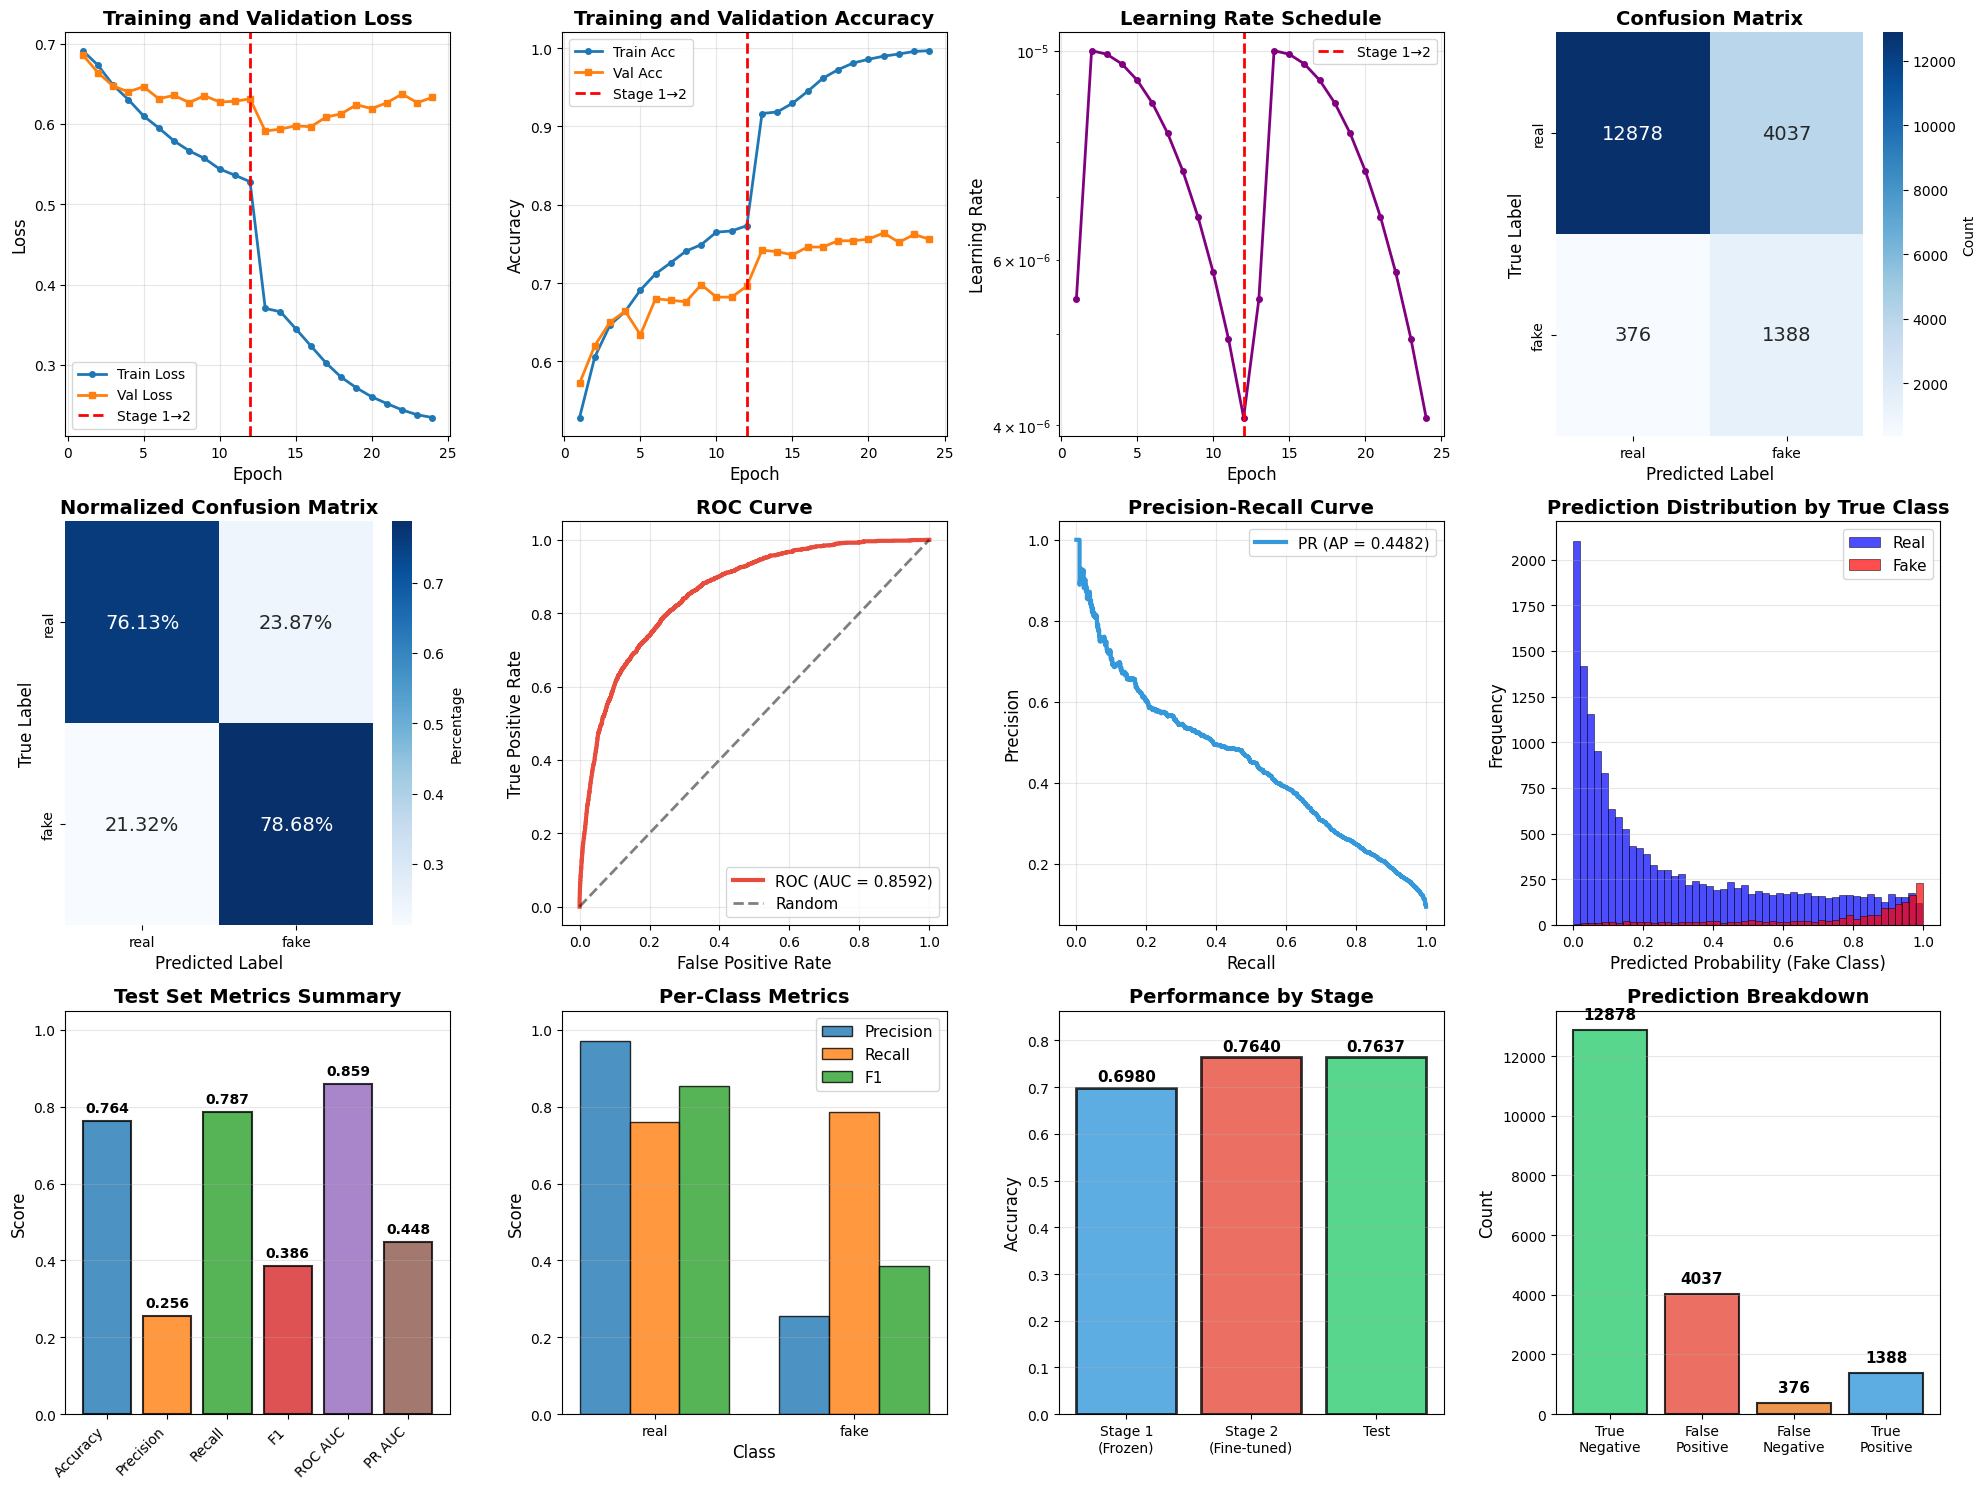


SAVING METRICS TO FILE
✅ Comprehensive metrics saved to: /content/drive/MyDrive/Final Project Adv ML/comprehensive_test_metrics.json

QUICK REFERENCE TABLE
     Metric  Score
   Accuracy 0.7637
  Precision 0.2559
     Recall 0.7868
   F1 Score 0.3861
Specificity 0.7613
Sensitivity 0.7868
    ROC AUC 0.8592
     PR AUC 0.4482

✅ EVALUATION COMPLETE!
📊 Visualization: /content/drive/MyDrive/Final Project Adv ML/comprehensive_results.png
📄 Metrics JSON: /content/drive/MyDrive/Final Project Adv ML/comprehensive_test_metrics.json
🎯 Final Test Accuracy: 0.7637 (76.37%)


In [ ]:
# ============================================================================
# COMPREHENSIVE EVALUATION AFTER STAGE 2
# ============================================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from datetime import datetime

# Enhanced evaluate function that returns predictions and probabilities
def evaluate_with_predictions(model, loader, criterion, device):
    """Evaluate model and return all predictions for detailed metrics"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            for images, labels in pbar:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(pixel_values=images)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

                running_loss += loss.item() * images.size(0)

                # Get probabilities and predictions
                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return avg_loss, all_preds, all_labels, all_probs


# ============================================================================
# GET DETAILED TEST PREDICTIONS
# ============================================================================

print("\n" + "="*70)
print("COMPREHENSIVE TEST SET EVALUATION")
print("="*70)

# Get detailed predictions on test set
test_loss_detailed, test_preds, test_labels, test_probs = evaluate_with_predictions(
    model, test_loader, criterion, device
)

# ============================================================================
# CALCULATE ALL METRICS
# ============================================================================

# Basic metrics
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='binary')
test_recall = recall_score(test_labels, test_preds, average='binary')
test_f1 = f1_score(test_labels, test_preds, average='binary')

# Per-class metrics
test_precision_per_class = precision_score(test_labels, test_preds, average=None)
test_recall_per_class = recall_score(test_labels, test_preds, average=None)
test_f1_per_class = f1_score(test_labels, test_preds, average=None)

# ROC AUC (using probability of positive class - fake)
test_roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

# Precision-Recall AUC
test_pr_auc = average_precision_score(test_labels, test_probs[:, 1])

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# Specificity and Sensitivity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall

# ============================================================================
# PRINT RESULTS
# ============================================================================

print(f"\n{'='*70}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*70}")
print(f"Stage 1 (Frozen) - Best Val Acc: {best_val_acc_stage1:.4f}")
print(f"Stage 2 (Fine-tuned) - Best Val Acc: {best_val_acc_stage2:.4f}")
improvement = best_val_acc_stage2 - best_val_acc_stage1
print(f"Improvement from fine-tuning: {improvement:+.4f} ({improvement*100:+.2f}%)")

print(f"\n{'='*70}")
print("TEST SET METRICS")
print(f"{'='*70}")

print(f"\n📊 Overall Metrics:")
print(f"   Loss:          {test_loss:.4f}")
print(f"   Accuracy:      {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision:     {test_precision:.4f}")
print(f"   Recall:        {test_recall:.4f}")
print(f"   F1 Score:      {test_f1:.4f}")
print(f"   Specificity:   {specificity:.4f}")
print(f"   Sensitivity:   {sensitivity:.4f}")
print(f"   ROC AUC:       {test_roc_auc:.4f}")
print(f"   PR AUC (AP):   {test_pr_auc:.4f}")

print(f"\n📊 Per-Class Metrics:")
class_names = ['real', 'fake']
for i, class_name in enumerate(class_names):
    print(f"\n   {class_name.upper()}:")
    print(f"      Precision: {test_precision_per_class[i]:.4f}")
    print(f"      Recall:    {test_recall_per_class[i]:.4f}")
    print(f"      F1 Score:  {test_f1_per_class[i]:.4f}")

print(f"\n📊 Confusion Matrix:")
print(f"                Predicted")
print(f"              Real  Fake")
print(f"   Actual Real  {cm[0][0]:5d} {cm[0][1]:5d}")
print(f"   Actual Fake  {cm[1][0]:5d} {cm[1][1]:5d}")

print(f"\n📊 Detailed Breakdown:")
print(f"   True Negatives (TN):  {tn:5d} (correctly identified real)")
print(f"   False Positives (FP): {fp:5d} (real predicted as fake)")
print(f"   False Negatives (FN): {fn:5d} (fake predicted as real)")
print(f"   True Positives (TP):  {tp:5d} (correctly identified fake)")

# ============================================================================
# DETAILED CLASSIFICATION REPORT
# ============================================================================

print(f"\n{'='*70}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*70}")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# ============================================================================
# COMPREHENSIVE VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(20, 15))

# Combine Stage 1 and Stage 2 histories
stage1_epochs = len(history_stage1['train_loss'])
all_train_loss = history_stage1['train_loss'] + history_stage2['train_loss']
all_train_acc = history_stage1['train_acc'] + history_stage2['train_acc']
all_val_loss = history_stage1['val_loss'] + history_stage2['val_loss']
all_val_acc = history_stage1['val_acc'] + history_stage2['val_acc']
all_lr = history_stage1['lr'] + history_stage2['lr']
epochs_range = range(1, len(all_train_loss) + 1)

# 1. Training History - Loss
plt.subplot(3, 4, 1)
plt.plot(epochs_range, all_train_loss, 'o-', label='Train Loss', linewidth=2, markersize=4)
plt.plot(epochs_range, all_val_loss, 's-', label='Val Loss', linewidth=2, markersize=4)
plt.axvline(x=stage1_epochs, color='red', linestyle='--', linewidth=2, label='Stage 1→2')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 2. Training History - Accuracy
plt.subplot(3, 4, 2)
plt.plot(epochs_range, all_train_acc, 'o-', label='Train Acc', linewidth=2, markersize=4)
plt.plot(epochs_range, all_val_acc, 's-', label='Val Acc', linewidth=2, markersize=4)
plt.axvline(x=stage1_epochs, color='red', linestyle='--', linewidth=2, label='Stage 1→2')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 3. Learning Rate Schedule
plt.subplot(3, 4, 3)
plt.plot(epochs_range, all_lr, 'o-', color='purple', linewidth=2, markersize=4)
plt.axvline(x=stage1_epochs, color='red', linestyle='--', linewidth=2, label='Stage 1→2')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 4. Confusion Matrix
plt.subplot(3, 4, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# 5. Normalized Confusion Matrix
plt.subplot(3, 4, 5)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'}, annot_kws={'size': 14})
plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# 6. ROC Curve
plt.subplot(3, 4, 6)
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
plt.plot(fpr, tpr, linewidth=3, label=f'ROC (AUC = {test_roc_auc:.4f})', color='#e74c3c')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 7. Precision-Recall Curve
plt.subplot(3, 4, 7)
precision_curve, recall_curve, _ = precision_recall_curve(test_labels, test_probs[:, 1])
plt.plot(recall_curve, precision_curve, linewidth=3, label=f'PR (AP = {test_pr_auc:.4f})', color='#3498db')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 8. Prediction Distribution
plt.subplot(3, 4, 8)
plt.hist(test_probs[test_labels == 0, 1], bins=50, alpha=0.7, label='Real',
         color='blue', edgecolor='black', linewidth=0.5)
plt.hist(test_probs[test_labels == 1, 1], bins=50, alpha=0.7, label='Fake',
         color='red', edgecolor='black', linewidth=0.5)
plt.xlabel('Predicted Probability (Fake Class)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Prediction Distribution by True Class', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# 9. Metrics Bar Chart
plt.subplot(3, 4, 9)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC']
values = [test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_pr_auc]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bars = plt.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylim([0, 1.05])
plt.ylabel('Score', fontsize=12)
plt.title('Test Set Metrics Summary', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.015,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 10. Per-Class Metrics
plt.subplot(3, 4, 10)
x = np.arange(len(class_names))
width = 0.25
bars1 = plt.bar(x - width, test_precision_per_class, width, label='Precision',
                alpha=0.8, edgecolor='black')
bars2 = plt.bar(x, test_recall_per_class, width, label='Recall',
                alpha=0.8, edgecolor='black')
bars3 = plt.bar(x + width, test_f1_per_class, width, label='F1',
                alpha=0.8, edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Per-Class Metrics', fontsize=14, fontweight='bold')
plt.xticks(x, class_names)
plt.legend(fontsize=11)
plt.ylim([0, 1.05])
plt.grid(True, alpha=0.3, axis='y')

# 11. Stage Comparison
plt.subplot(3, 4, 11)
stages = ['Stage 1\n(Frozen)', 'Stage 2\n(Fine-tuned)', 'Test']
accs = [best_val_acc_stage1, best_val_acc_stage2, test_acc]
colors_stage = ['#3498db', '#e74c3c', '#2ecc71']
bars = plt.bar(stages, accs, color=colors_stage, alpha=0.8, edgecolor='black', linewidth=2)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Performance by Stage', fontsize=14, fontweight='bold')
plt.ylim([0, max(accs) + 0.1])
for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# 12. Error Analysis
plt.subplot(3, 4, 12)
error_types = ['True\nNegative', 'False\nPositive', 'False\nNegative', 'True\nPositive']
error_counts = [tn, fp, fn, tp]
error_colors = ['#2ecc71', '#e74c3c', '#e67e22', '#3498db']
bars = plt.bar(error_types, error_counts, color=error_colors, alpha=0.8,
               edgecolor='black', linewidth=1.5)
plt.ylabel('Count', fontsize=12)
plt.title('Prediction Breakdown', fontsize=14, fontweight='bold')
for bar, count in zip(bars, error_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(error_counts)*0.02,
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
save_path_viz = '/content/drive/MyDrive/Final Project Adv ML/comprehensive_results.png'
plt.savefig(save_path_viz, dpi=300, bbox_inches='tight')
print(f"✅ Visualization saved to: {save_path_viz}")
plt.show()

# ============================================================================
# SAVE COMPREHENSIVE METRICS TO JSON
# ============================================================================

print("\n" + "="*70)
print("SAVING METRICS TO FILE")
print("="*70)

metrics_dict = {
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'training_stages': {
        'stage1': {
            'description': 'Frozen backbone, trained classifier only',
            'best_val_acc': float(best_val_acc_stage1),
            'epochs_trained': len(history_stage1['train_loss'])
        },
        'stage2': {
            'description': f'Fine-tuned last {num_layers_to_unfreeze} layers',
            'best_val_acc': float(best_val_acc_stage2),
            'epochs_trained': len(history_stage2['train_loss']),
            'improvement_over_stage1': float(improvement)
        }
    },
    'test_metrics': {
        'accuracy': float(test_acc),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1),
        'specificity': float(specificity),
        'sensitivity': float(sensitivity),
        'roc_auc': float(test_roc_auc),
        'pr_auc': float(test_pr_auc),
        'loss': float(test_loss)
    },
    'per_class_metrics': {
        'real': {
            'precision': float(test_precision_per_class[0]),
            'recall': float(test_recall_per_class[0]),
            'f1_score': float(test_f1_per_class[0])
        },
        'fake': {
            'precision': float(test_precision_per_class[1]),
            'recall': float(test_recall_per_class[1]),
            'f1_score': float(test_f1_per_class[1])
        }
    },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'training_history': {
        'stage1': history_stage1,
        'stage2': history_stage2
    }
}

metrics_path = '/content/drive/MyDrive/Final Project Adv ML/comprehensive_test_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"✅ Comprehensive metrics saved to: {metrics_path}")

# ============================================================================
# SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("QUICK REFERENCE TABLE")
print("="*70)

import pandas as pd

summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity',
               'Sensitivity', 'ROC AUC', 'PR AUC'],
    'Score': [f"{test_acc:.4f}", f"{test_precision:.4f}", f"{test_recall:.4f}",
              f"{test_f1:.4f}", f"{specificity:.4f}", f"{sensitivity:.4f}",
              f"{test_roc_auc:.4f}", f"{test_pr_auc:.4f}"]
}

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)
print(f"📊 Visualization: {save_path_viz}")
print(f"📄 Metrics JSON: {metrics_path}")
print(f"🎯 Final Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("="*70)

## Explanability + Attention Rollout / GradCAM 

In [ ]:
FRAME_OUTPUT_DIR = "/content/drive/MyDrive/Final Project Adv ML/celeb-df-v2/frames"
# FRAME_OUTPUT_DIR = "/content/drive/MyDrive/frames"


# 1. Define Image Preprocessing Transforms
IMAGE_SIZE = 224  # common size for many HF vision models
mean = [0.485, 0.456, 0.406]  # ImageNet means
std = [0.229, 0.224, 0.225]   # ImageNet stds

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

full_dataset = datasets.ImageFolder(root=FRAME_OUTPUT_DIR, transform=transform)

print("Classes:", full_dataset.classes)  # e.g., ['fake', 'real']
targets = np.array(full_dataset.targets)
num_samples = len(full_dataset)
print("Total Frames:", num_samples)

# 3. Define stratified splits (80% train, 10% val, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

indices = np.arange(num_samples)

# First split: train vs (val+test)
train_indices, val_test_indices = train_test_split(
    indices,
    train_size=train_ratio,
    stratify=targets,
    random_state=42
)

# Second split: val vs test from remaining
val_test_targets = targets[val_test_indices]
val_size_relative = val_ratio / (val_ratio + test_ratio)  # = 0.5 if 10/10

val_indices, test_indices = train_test_split(
    val_test_indices,
    train_size=val_size_relative,
    stratify=val_test_targets,
    random_state=42
)

# Create Subset datasets
train_data = Subset(full_dataset, train_indices)
val_data   = Subset(full_dataset, val_indices)
test_data  = Subset(full_dataset, test_indices)

print(f"Train size: {len(train_data)} | Val size: {len(val_data)} | Test size: {len(test_data)}")

# 4. Create DataLoaders
BATCH_SIZE = 32  # can tune this later

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Validation batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Classes: ['fake', 'real']
Total Frames: 186781
Train size: 149424 | Val size: 18678 | Test size: 18679
Train batches: 4670 | Validation batches: 584 | Test batches: 584


In [ ]:
!pip install -q transformers accelerate

import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor

In [ ]:
HIDDEN_DIM = 512
# === Cell 6: Load trained ViT + MLP head from checkpoint ===
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 1. Define the same MLPHead class they used in training ---
class MLPHead(nn.Module):
    def __init__(self, in_features, hidden_dim=HIDDEN_DIM, num_labels=2, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),             # they used ReLU
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels)
        )

    def forward(self, x):
        return self.net(x)

# --- 2. Rebuild the base ViT model exactly like training code ---
model_name = "prithivMLmods/Deep-Fake-Detector-v2-Model"

id2label = {0: "real", 1: "fake"}
label2id = {"real": 0, "fake": 1}

print("\nLoading base pretrained model...")
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

# (Optional) load processor if you need it later
processor = ViTImageProcessor.from_pretrained(model_name)

print("Base model loaded:", model_name)

# --- 3. Freeze ViT backbone (same as training) ---
for p in model.vit.parameters():
    p.requires_grad = False

# --- 4. Replace classifier with the SAME MLP head they used ---
in_features = model.classifier.in_features
model.classifier = MLPHead(
    in_features=in_features,
    hidden_dim=HIDDEN_DIM,
    num_labels=2,
    dropout=0.1,
)

# Keep config consistent
model.config.num_labels = 2
model.config.id2label = id2label
model.config.label2id = label2id

model.to(device)

# --- 5. Load checkpoint weights from their training run ---
checkpoint_path = "/content/drive/MyDrive/Final Project Adv ML/stage2_finetuned_best.pt" #baseline_deepfake_vit_best
print("\nLoading checkpoint from:", checkpoint_path)
checkpoint = torch.load(checkpoint_path, map_location=device)

state_dict = checkpoint["model_state_dict"]

# If they used torch.compile, keys probably have "_orig_mod." prefix.
# Strip it if present.
clean_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("_orig_mod."):
        new_k = k[len("_orig_mod."):]
    else:
        new_k = k
    clean_state_dict[new_k] = v

missing, unexpected = model.load_state_dict(clean_state_dict, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.eval()
print("✅ Loaded trained model from checkpoint.")
print("Checkpoint validation accuracy:", checkpoint.get("val_acc", "N/A"))


Using device: cuda

Loading base pretrained model...
Base model loaded: prithivMLmods/Deep-Fake-Detector-v2-Model

Loading checkpoint from: /content/drive/MyDrive/Final Project Adv ML/stage2_finetuned_best.pt
Missing keys: []
Unexpected keys: []
✅ Loaded trained model from checkpoint.
Checkpoint validation accuracy: 0.764


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None

        # Hook the classifier for gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]   # (B, 2)

        model.classifier.register_backward_hook(backward_hook)

    def generate_cam(self, hidden_states, class_idx):
        """
        hidden_states: (B, tokens, hidden_dim)
        gradients:     (B, 2) from classifier output
        """
        # Take gradient of chosen class
        grads = self.gradients[:, class_idx]  # (B, )

        # Expand to match hidden_state dimension
        grads = grads.unsqueeze(-1)           # (B, 1)
        grads = grads.unsqueeze(-1)           # (B, 1, 1)

        # Weighted sum across hidden dim
        cam = (hidden_states * grads).sum(dim=-1)  # (B, tokens)
        cam = cam[:, 1:]  # remove CLS token

        # Normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        return cam


In [ ]:
def run_gradcam_on_dataset_index(dataset, index, gradcam):
    img_tensor, label = dataset[index]
    img_input = img_tensor.unsqueeze(0).to(device)

    # Forward WITH hidden states
    outputs = model(pixel_values=img_input, output_hidden_states=True)
    logits = outputs.logits
    hidden_states = outputs.hidden_states[-1]   # final ViT layer (B, tokens, dim)

    pred_class = logits.argmax(dim=1).item()

    # Backprop to get gradients
    model.zero_grad()
    logits[0, pred_class].backward()

    # Generate CAM
    cam_flat = gradcam.generate_cam(hidden_states, pred_class)[0]
    cam = cam_flat.reshape(14, 14).detach().cpu().numpy()

    # Normalize
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    # Undo normalization on image
    orig = img_tensor.permute(1, 2, 0).cpu().numpy()
    orig = (orig * np.array([0.229, 0.224, 0.225]) +
           np.array([0.485, 0.456, 0.406]))
    orig = np.clip(orig, 0, 1)
    orig = (orig * 255).astype(np.uint8)

    # Overlay
    overlay = overlay_heatmap(orig, cam)

    return orig, overlay, pred_class, label


def overlay_heatmap(image, cam, alpha=0.4):
    """
    image: (H, W, 3) uint8 original image
    cam:   (H', W') activation map in [0,1] (ViT = 14x14)
    """

    # Resize CAM to original image size
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))

    # Convert to heatmap (OpenCV returns BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay with alpha blending
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


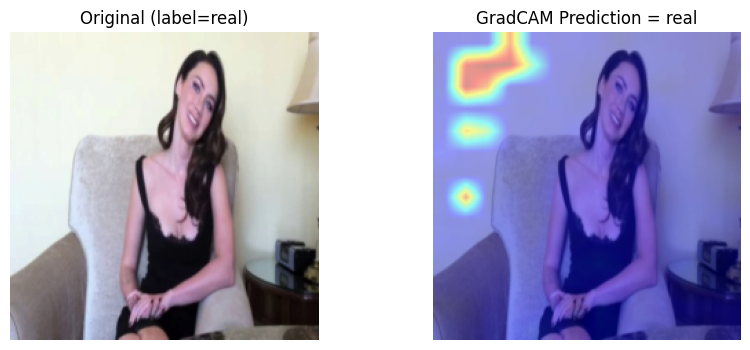

In [ ]:
gradcam = ViTGradCAM(model)

idx = 10
orig, overlay, pred, true = run_gradcam_on_dataset_index(val_data, idx, gradcam)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(f"Original (label={id2label[true]})")
plt.imshow(orig)
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"GradCAM Prediction = {id2label[pred]}")
plt.imshow(overlay)
plt.axis("off")

plt.show()


What the above code does:

1. Gets the final transformer hidden states reliably using output_hidden_states=True.

2. Hooks only the classifier to get gradients.

3. Computes a ViT-compatible GradCAM map from hidden states × gradients.

4. Converts patch tokens into a spatial heatmap.

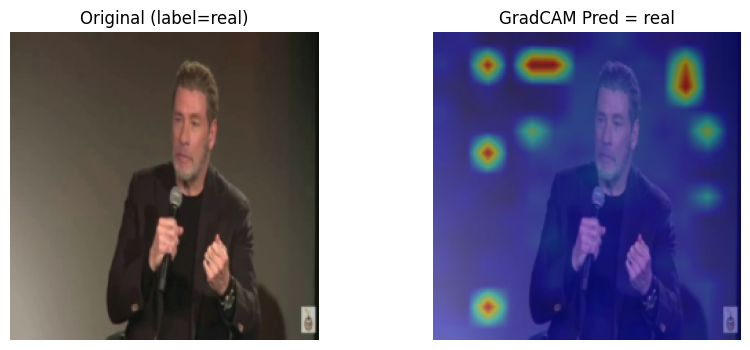

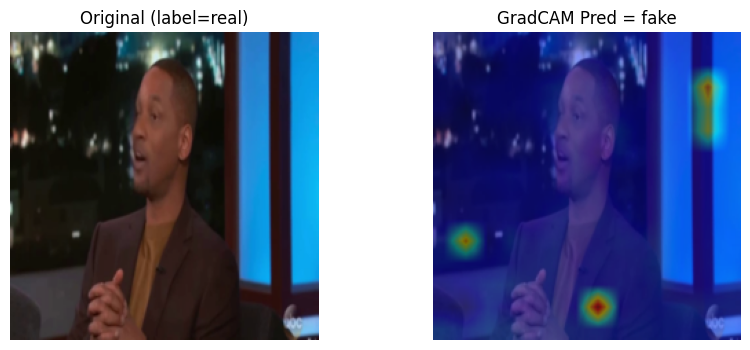

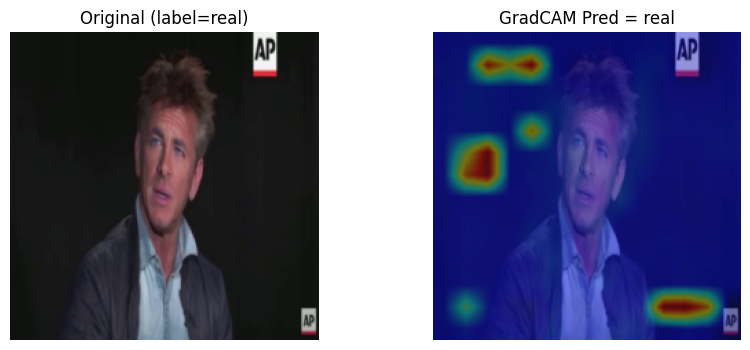

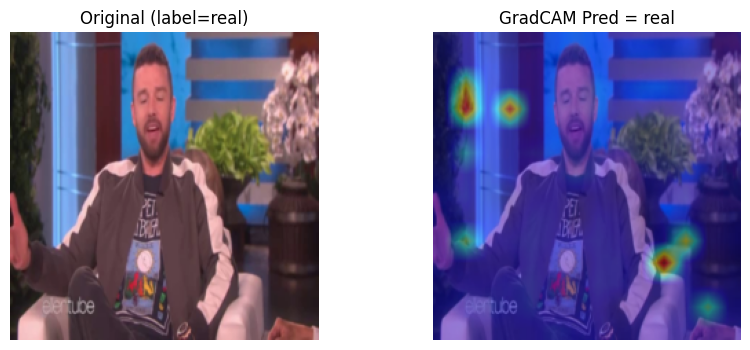

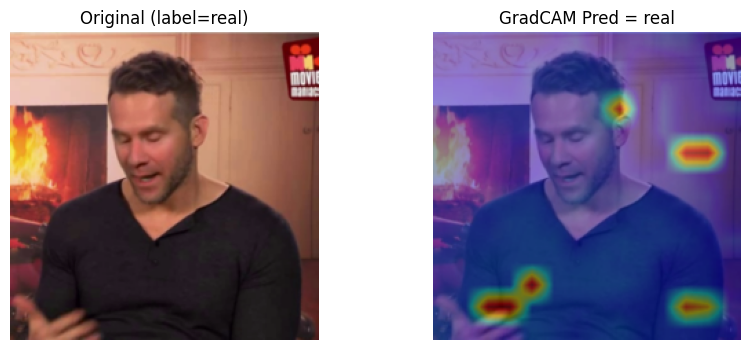

In [ ]:
import random

indices = random.sample(range(len(val_data)), 5)  # pick 5 random samples

for idx in indices:
    orig, overlay, pred, true = run_gradcam_on_dataset_index(val_data, idx, gradcam)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(orig)
    plt.title(f"Original (label={id2label[true]})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"GradCAM Pred = {id2label[pred]}")
    plt.axis("off")

    plt.show()


### Trying Attention Rollout instead of GradCam for hopefully more precise heatmaps. Hard to tell currently with our results.

In [ ]:
def get_attention_rollout(model, pixel_values, discard_ratio=0.0):
    """
    Compute attention rollout for HuggingFace ViT.
    """
    # Forward pass with attention outputs
    outputs = model(
        pixel_values=pixel_values,
        output_attentions=True
    )

    # List of attention matrices: length = num_layers
    attentions = outputs.attentions
    # Shape per layer: (batch, num_heads, tokens, tokens)

    # Average heads
    attn_avg_heads = [att.mean(dim=1) for att in attentions]
    # Shape: (batch, tokens, tokens)

    # Apply attention rollout
    rollout = attn_avg_heads[0]

    for i in range(1, len(attn_avg_heads)):
        attn = attn_avg_heads[i]

        # Optional: discard low attentions
        if discard_ratio > 0:
            flat = attn.reshape(attn.shape[0], -1)
            threshold = flat.quantile(discard_ratio, dim=1).unsqueeze(1).unsqueeze(1)
            attn = torch.where(attn < threshold, torch.zeros_like(attn), attn)

        # Normalize
        attn = attn / attn.sum(dim=-1, keepdim=True)

        rollout = attn @ rollout  # chain attention

    # rollout shape: (batch, tokens, tokens)
    return rollout

def generate_rollout_heatmap(rollout, image_shape=(224,224), patch_size=16):
    """
    Convert rollout (attention to each token) into a 2D heatmap.
    """
    rollout_map = rollout[0, 0, 1:]   # CLS token attention to all patches
    num_patches = rollout_map.shape[0]

    # Reshape into grid
    grid_size = int(np.sqrt(num_patches))
    cam = rollout_map.reshape(grid_size, grid_size).detach().cpu().numpy()

    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)

    # Resize to image resolution
    cam = cv2.resize(cam, image_shape)

    return cam


    import matplotlib.cm as cm

def visualize_rollout(idx, dataset, model):
    img_tensor, label = dataset[idx]
    img = img_tensor.unsqueeze(0).to(device)

    # Forward with rollout
    rollout = get_attention_rollout(model, img)

    # Build heatmap
    cam = generate_rollout_heatmap(rollout)

    # Recover original image
    orig = img_tensor.permute(1,2,0).cpu().numpy()
    orig = (orig * np.array([0.229, 0.224, 0.225]) +
                  np.array([0.485, 0.456, 0.406]))
    orig = np.clip(orig, 0, 1)
    orig = (orig * 255).astype(np.uint8)

    heatmap_colored = cm.jet(cam)[:, :, :3]  # Get RGB, drop alpha
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)

    overlay = cv2.addWeighted(orig, 0.6, heatmap_colored, 0.4, 0)

    # Plot
    pred = model(pixel_values=img).logits.argmax(dim=1).item()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title(f"Original (label={id2label[label]})")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap='jet')
    plt.title("Attention Rollout Map")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title(f"Overlay (Pred={id2label[pred]})")
    plt.axis("off")

    plt.show()

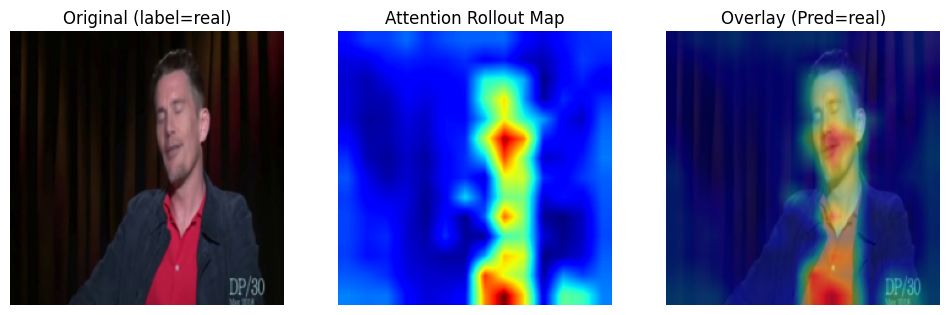

In [ ]:
import matplotlib.cm as cm

model.set_attn_implementation("eager")

visualize_rollout(idx=15, dataset=val_data, model=model)

In [ ]:
# full_dataset: ImageFolder
# val_data: Subset(full_dataset, val_indices)

full_targets = np.array(full_dataset.dataset.targets)         # labels for all images
val_subset_indices = np.array(val_data.indices)       # indices into full_dataset

val_labels = full_targets[val_subset_indices]         # labels for val subset

# Now build indices *within val_data* (0 .. len(val_data)-1)
real_indices = np.where(val_labels == 0)[0].tolist()
fake_indices = np.where(val_labels == 1)[0].tolist()

print("Real samples in val:", len(real_indices))
print("Fake samples in val:", len(fake_indices))

AttributeError: 'ImageFolder' object has no attribute 'dataset'

In [ ]:
import random

model.set_attn_implementation("eager")
print("Attention implementation:", model.config._attn_implementation)

def visualize_rollout_grid(dataset, model, real_indices, fake_indices, n_each=5):
    # Choose N real and N fake
    chosen_real = random.sample(real_indices, n_each)
    chosen_fake = random.sample(fake_indices, n_each)
    chosen = chosen_real + chosen_fake

    plt.figure(figsize=(20, 8))

    for i, idx in enumerate(chosen):
        img_tensor, label = dataset[idx]
        img = img_tensor.unsqueeze(0).to(device)

        # Rollout
        rollout = get_attention_rollout(model, img)
        cam = generate_rollout_heatmap(rollout)

        # Undo normalization
        orig = img_tensor.permute(1, 2, 0).cpu().numpy()
        orig = (orig * np.array([0.229, 0.224, 0.225]) +
                      np.array([0.485, 0.456, 0.406]))
        orig = np.clip(orig, 0, 1)
        orig = (orig * 255).astype(np.uint8)

        # Overlay - FIXED: Use matplotlib's jet colormap instead of OpenCV
        heatmap_colored = cm.jet(cam)[:, :, :3]  # Get RGB, drop alpha
        heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
        overlay = cv2.addWeighted(orig, 0.6, heatmap_colored, 0.4, 0)

        # Prediction
        pred = model(pixel_values=img).logits.argmax(dim=1).item()

        # Plot
        plt.subplot(2, n_each, i+1)
        plt.imshow(overlay)
        plt.title(f"{id2label[label]} | Pred={id2label[pred]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# RUN IT
visualize_rollout_grid(val_data, model, real_indices, fake_indices, n_each=5)


Attention implementation: eager


NameError: name 'real_indices' is not defined

### Comparing one real vs one fake image heatmap w/ overlay

In [ ]:
def visualize_real_vs_fake(real_idx, fake_idx, dataset, model):
    indices = [("REAL", real_idx), ("FAKE", fake_idx)]

    plt.figure(figsize=(14, 6))

    for i, (label_name, idx) in enumerate(indices):
        img_tensor, label = dataset[idx]
        img = img_tensor.unsqueeze(0).to(device)

        # Rollout
        rollout = get_attention_rollout(model, img)
        cam = generate_rollout_heatmap(rollout)

        # Undo normalization
        orig = img_tensor.permute(1, 2, 0).cpu().numpy()
        orig = (orig * np.array([0.229, 0.224, 0.225]) +
                      np.array([0.485, 0.456, 0.406]))
        orig = np.clip(orig, 0, 1)
        orig = (orig * 255).astype(np.uint8)

        # Overlay - FIXED: Use matplotlib's jet colormap instead of OpenCV
        heatmap_colored = cm.jet(cam)[:, :, :3]  # Get RGB, drop alpha
        heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
        overlay = cv2.addWeighted(orig, 0.6, heatmap_colored, 0.4, 0)

        # Prediction
        pred = model(pixel_values=img).logits.argmax(dim=1).item()

        # Plot
        plt.subplot(1, 2, i + 1)
        plt.imshow(overlay)
        plt.title(f"{label_name}\nPred={id2label[pred]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Pick one real and one fake
real_idx = random.choice(real_indices)
fake_idx = random.choice(fake_indices)

visualize_real_vs_fake(real_idx, fake_idx, val_data, model)


NameError: name 'real_indices' is not defined